/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

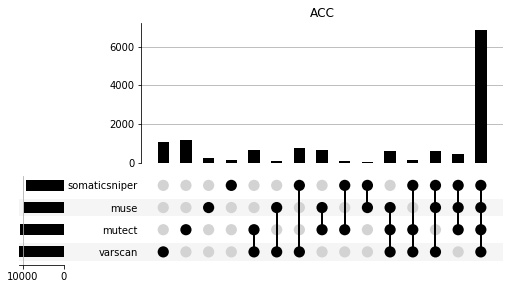

<Figure size 432x288 with 0 Axes>

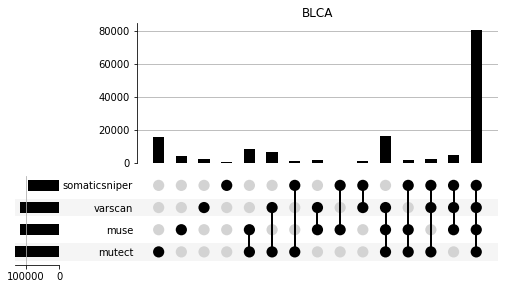

<Figure size 432x288 with 0 Axes>

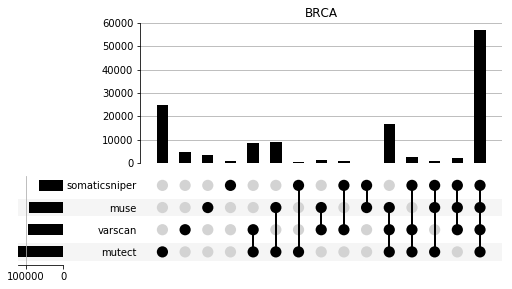

<Figure size 432x288 with 0 Axes>

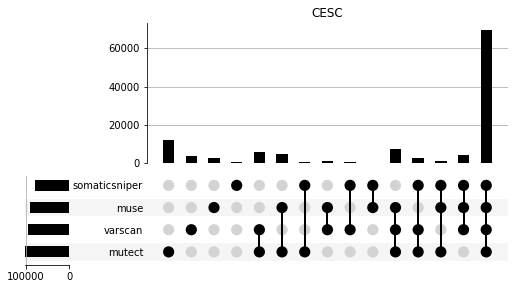

<Figure size 432x288 with 0 Axes>

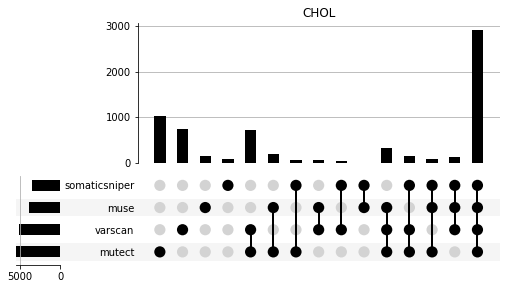

<Figure size 432x288 with 0 Axes>

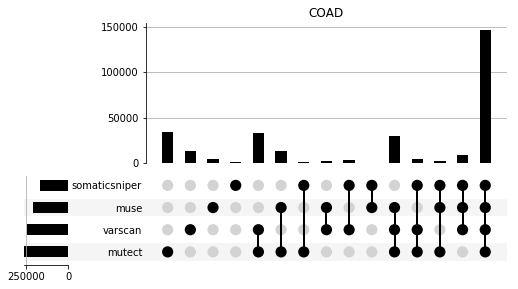

<Figure size 432x288 with 0 Axes>

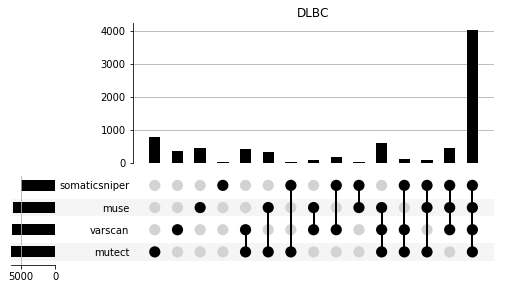

<Figure size 432x288 with 0 Axes>

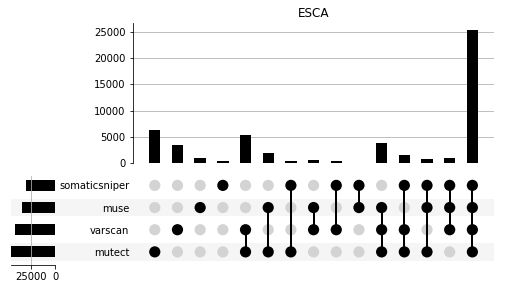

<Figure size 432x288 with 0 Axes>

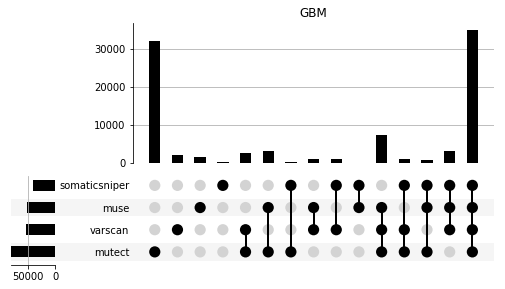

<Figure size 432x288 with 0 Axes>

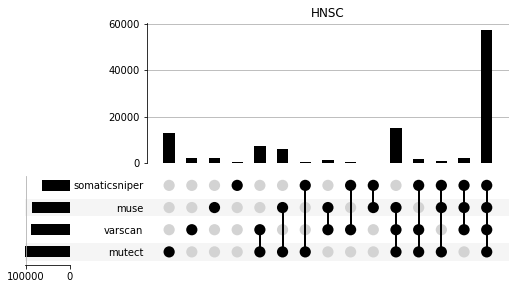

<Figure size 432x288 with 0 Axes>

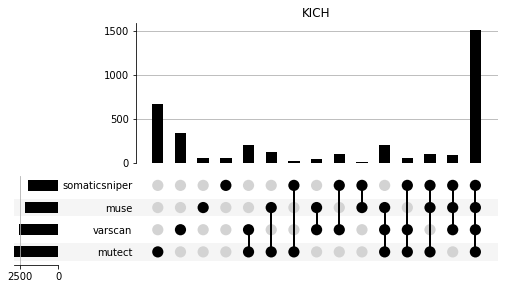

<Figure size 432x288 with 0 Axes>

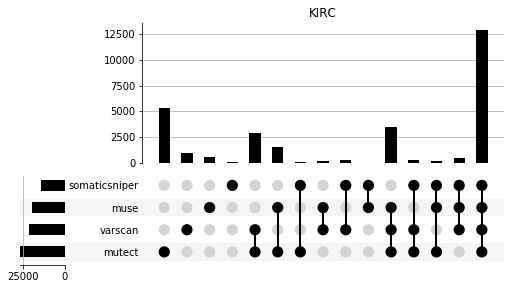

<Figure size 432x288 with 0 Axes>

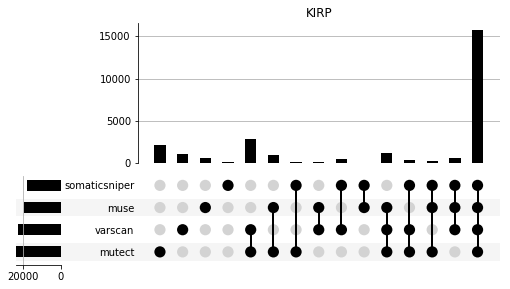

<Figure size 432x288 with 0 Axes>

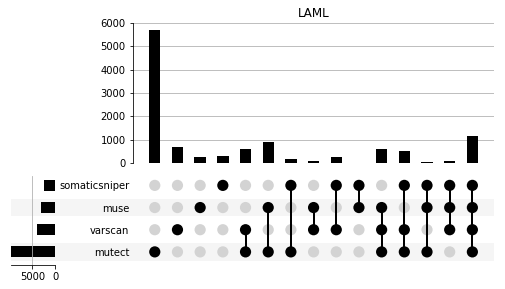

<Figure size 432x288 with 0 Axes>

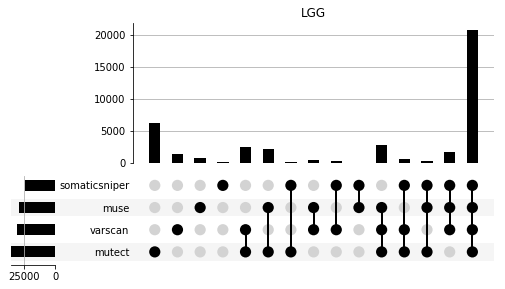

<Figure size 432x288 with 0 Axes>

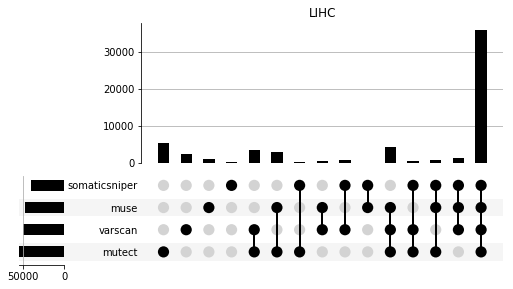

<Figure size 432x288 with 0 Axes>

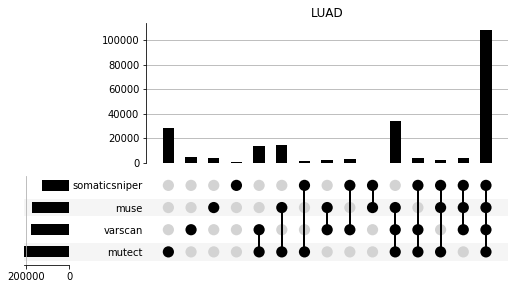

<Figure size 432x288 with 0 Axes>

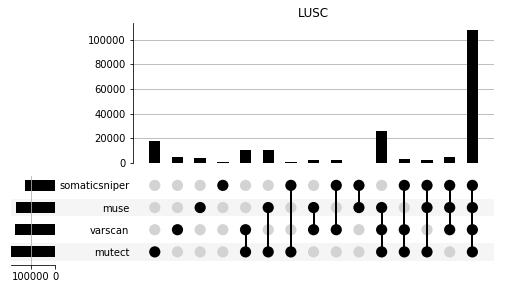

<Figure size 432x288 with 0 Axes>

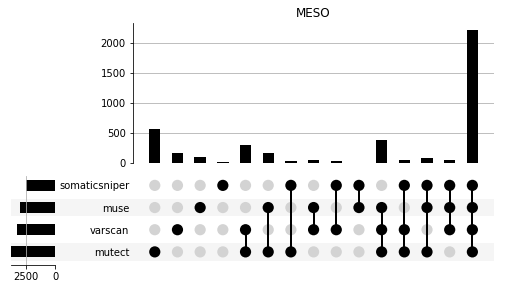

In [1]:
import os, sys, argparse
from upsetplot import from_memberships
from upsetplot import plot
%matplotlib inline 
from matplotlib import pyplot
# functions
def parse_maf(fp):
	''' Return a dictionary with vars[patient][variant_set]'''
	caller_vars = {}

	fh = open(fp, 'r')
	for line in fh:
		temp = line.strip().split('\t')
		if line[0] == '#' or temp[0] == 'Hugo_Symbol':
			continue
		ID = temp[16] + '_' + temp[17] # 'tumor'_'normal'
		if ID not in caller_vars:
			caller_vars[ID] = set()
		chrom =temp[4]
		s_pos = temp[5]
		e_pos = temp[6]
		ref = temp[11]
		tum_allele_1 = temp[12]
		tum_allele_2 = temp[13]
		var = (chrom, s_pos, e_pos, ref, tum_allele_1, tum_allele_2)
		caller_vars[ID].add(var)

	return(caller_vars)


def two_set(dat_1, dat_2):
    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys()))
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        inter = len(set_1 & set_2)
        diff_1 = len(set_1 - set_2)
        diff_2 = len(set_2 - set_1)

        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
    
    dat.extend([inter_all, diff_1_all, diff_2_all])
    return dat


def three_set(dat_1, dat_2, dat_3):

    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    inter_12_all = 0
    inter_13_all = 0
    inter_23_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys()))
    
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        inter = len(set_1 & set_2 & set_3)
        inter_12 = len(set_1 & set_2) - inter
        inter_13 = len(set_1 & set_3) - inter
        inter_23 = len(set_2 & set_3) - inter
        diff_1 = len(set_1) - inter - inter_13 - inter_12
        diff_2 = len(set_2) - inter - inter_12 - inter_23
        diff_3 = len(set_3) - inter - inter_13 - inter_23
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_23_all = inter_23_all + inter_23

    dat.extend([inter_all, diff_1_all, diff_2_all, diff_3_all, inter_12_all, inter_13_all, inter_23_all])
    return dat


def four_set(dat_1, dat_2, dat_3, dat_4):
    dat = []
    inter_all = 0
    
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    diff_4_all = 0
    
    inter_12_all = 0
    inter_13_all = 0
    inter_14_all = 0
    inter_23_all = 0
    inter_24_all = 0
    inter_34_all = 0
    
    inter_123_all = 0
    inter_124_all = 0
    inter_134_all = 0
    inter_234_all = 0    
    
    set1_total = 0
    set2_total = 0
    set3_total = 0
    set4_total = 0
    
    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys())) & set(list(dat_4.keys()))
    total = 0
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        set_4 = dat_4[patient]
        
        set1_total = set1_total + len(set_1)
        set2_total = set2_total + len(set_2)
        set3_total = set3_total + len(set_3)
        set4_total = set4_total + len(set_4)
        
        
        inter = len(set_1 & set_2 & set_3 & set_4)
        inter_123 = len(set_1 & set_2 & set_3) - inter
        inter_124 = len(set_1 & set_2 & set_4) - inter
        inter_134 = len(set_1 & set_3 & set_4) - inter
        inter_234 = len(set_2 & set_3 & set_4) - inter
        
        
        inter_12 = len(set_1 & set_2) - inter - inter_123 - inter_124
        inter_13 = len(set_1 & set_3) - inter - inter_123 - inter_134
        inter_14 = len(set_1 & set_4) - inter - inter_124 - inter_134
        inter_23 = len(set_2 & set_3) - inter - inter_123 - inter_234
        inter_24 = len(set_2 & set_4) - inter - inter_124 - inter_234
        inter_34 = len(set_3 & set_4) - inter - inter_234 - inter_134
        
        diff_1 = len(set_1) - inter - inter_13 - inter_12 - inter_14 - inter_123 - inter_134 - inter_124
        diff_2 = len(set_2) - inter - inter_12 - inter_23 - inter_24 - inter_123 - inter_124 - inter_234
        diff_3 = len(set_3) - inter - inter_13 - inter_23 - inter_34 - inter_123 - inter_134 - inter_234
        diff_4 = len(set_4) - inter - inter_14 - inter_24 - inter_34 - inter_124 - inter_134 - inter_234
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        diff_4_all = diff_4_all + diff_4
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_14_all = inter_14_all + inter_14
        inter_23_all = inter_23_all + inter_23
        inter_24_all = inter_24_all + inter_24
        inter_34_all = inter_34_all + inter_34
        inter_123_all = inter_123_all + inter_123
        inter_124_all = inter_124_all + inter_124
        inter_134_all = inter_134_all + inter_134
        inter_234_all = inter_234_all + inter_234
        total = total + len(set_1 & set_2)
    
    #print(set1_total)
    #print(set2_total)
    #print(set3_total)
    #print(set4_total)
    
    dat.extend([inter_all, diff_1_all, diff_2_all, diff_3_all, diff_4_all, inter_12_all, inter_13_all, inter_14_all,
                inter_23_all, inter_24_all, inter_34_all, inter_123_all, inter_124_all, inter_134_all, inter_234_all]) 
    
    return dat



# main
possible_callers = ('mutect', 'muse', 'somaticsniper', 'varscan')
#not all possible cancers, just for testing
possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD','DLBC','ESCA','GBM','HNSC', 
					'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO')


original = os.getcwd()
for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    #print(possible_callers)
    #print(maf_fps)

    # parse maf for each caller
    all_variants = {}
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    num_callers = len(possible_callers)
    dat = []
    
    """
    #two ways
    
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            set_vals = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
            dat.append(set_vals)
            print(possible_callers[i], possible_callers[j])
            print(set_vals)
    """
    """
    # three ways 
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            for k in range(j+1, num_callers):
                set_vals = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
                dat.append(set_vals)
                print(possible_callers[i], possible_callers[j], possible_callers[k])
                print(set_vals)
    
    
    print(four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]]))
    """
    
    # four way intersection    
    dat = four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]])
    #print(possible_callers[0], possible_callers[1], possible_callers[2], possible_callers[3])
    #print(set_vals)
    
    example = from_memberships([['mutect','muse','somaticsniper','varscan'],['mutect'], ['muse'], ['somaticsniper'], 
                                ['varscan'], ['mutect', 'muse'],['mutect', 'somaticsniper'],['mutect', 'varscan'],['muse','somaticsniper'], ['muse', 'varscan'],
                            ['somaticsniper', 'varscan'],['mutect', 'muse', 'somaticsniper'], ['mutect','muse','varscan'], ['mutect', 'somaticsniper', 'varscan'],
                            ['muse','somaticsniper','varscan']],
                           data=dat)
    pyplot.figure()
    plot(example)  
    pyplot.title(cancer)
    


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

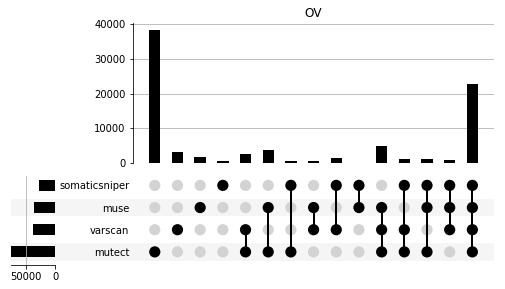

<Figure size 432x288 with 0 Axes>

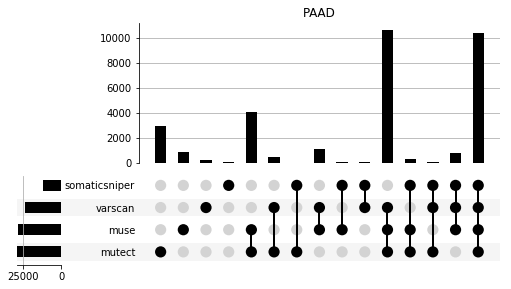

<Figure size 432x288 with 0 Axes>

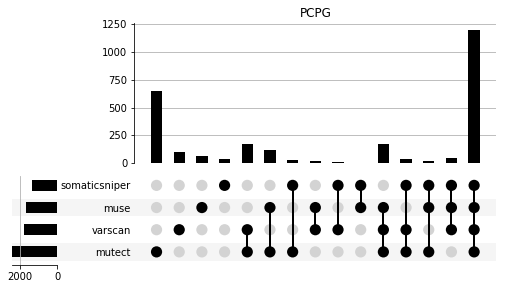

<Figure size 432x288 with 0 Axes>

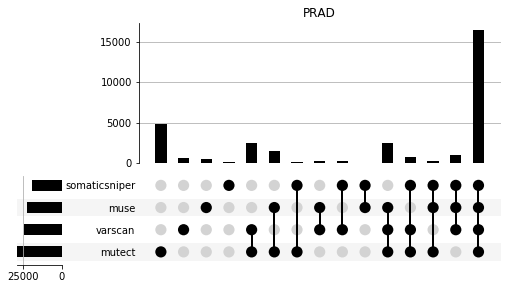

<Figure size 432x288 with 0 Axes>

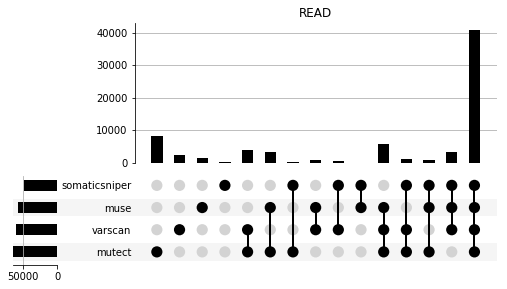

<Figure size 432x288 with 0 Axes>

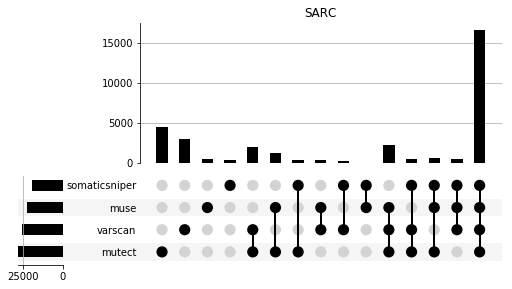

<Figure size 432x288 with 0 Axes>

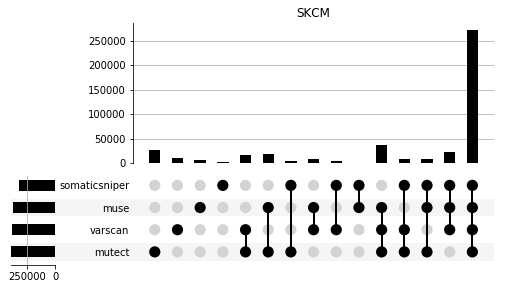

<Figure size 432x288 with 0 Axes>

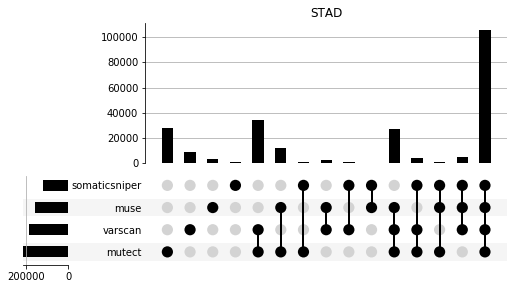

<Figure size 432x288 with 0 Axes>

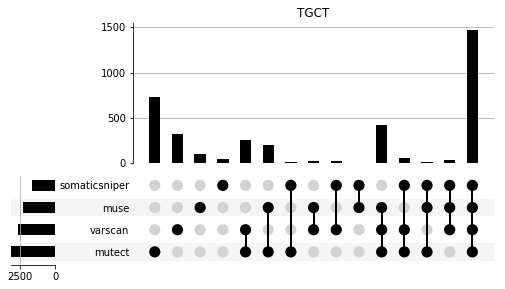

<Figure size 432x288 with 0 Axes>

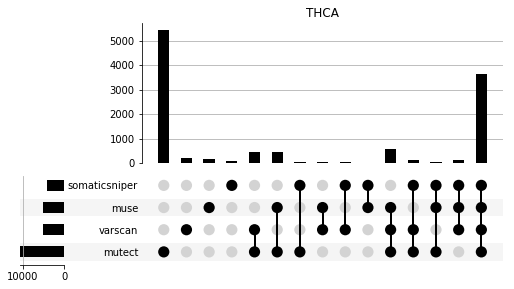

<Figure size 432x288 with 0 Axes>

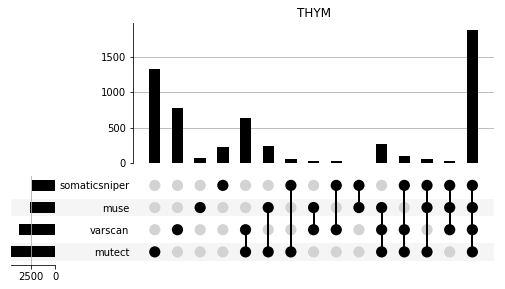

<Figure size 432x288 with 0 Axes>

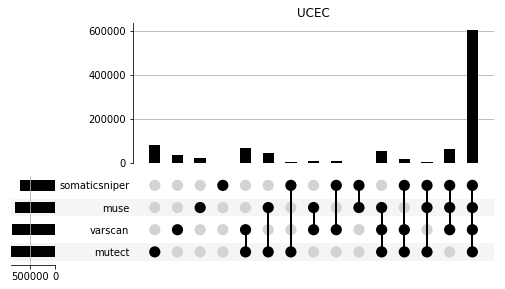

<Figure size 432x288 with 0 Axes>

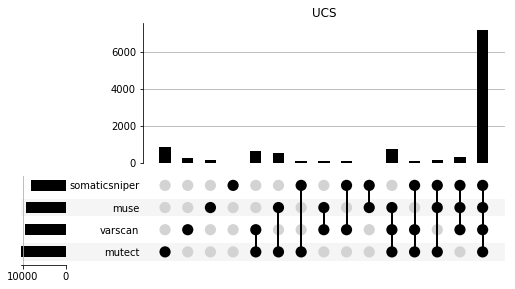

<Figure size 432x288 with 0 Axes>

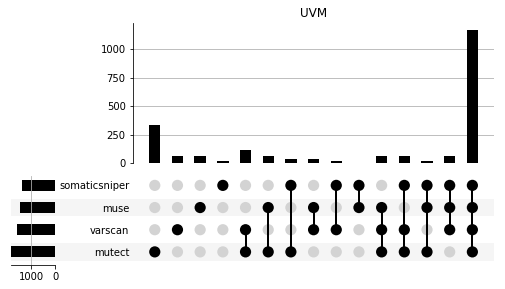

In [2]:
os.chdir(original)
possible_cancers = ('OV','PAAD','PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')
for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    #print(possible_callers)
    #print(maf_fps)

    # parse maf for each caller
    all_variants = {}
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    num_callers = len(possible_callers)
    dat = []
    
    """
    #two ways
    
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            set_vals = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
            dat.append(set_vals)
            print(possible_callers[i], possible_callers[j])
            print(set_vals)
    """
    """
    # three ways 
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            for k in range(j+1, num_callers):
                set_vals = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
                dat.append(set_vals)
                print(possible_callers[i], possible_callers[j], possible_callers[k])
                print(set_vals)
    
    
    print(four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]]))
    """
    
    # four way intersection    
    dat = four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]])
    #print(possible_callers[0], possible_callers[1], possible_callers[2], possible_callers[3])
    #print(set_vals)
    
    example = from_memberships([['mutect','muse','somaticsniper','varscan'],['mutect'], ['muse'], ['somaticsniper'], 
                                ['varscan'], ['mutect', 'muse'],['mutect', 'somaticsniper'],['mutect', 'varscan'],['muse','somaticsniper'], ['muse', 'varscan'],
                            ['somaticsniper', 'varscan'],['mutect', 'muse', 'somaticsniper'], ['mutect','muse','varscan'], ['mutect', 'somaticsniper', 'varscan'],
                            ['muse','somaticsniper','varscan']],
                           data=dat)
    pyplot.figure()
    plot(example)  
    pyplot.title(cancer)

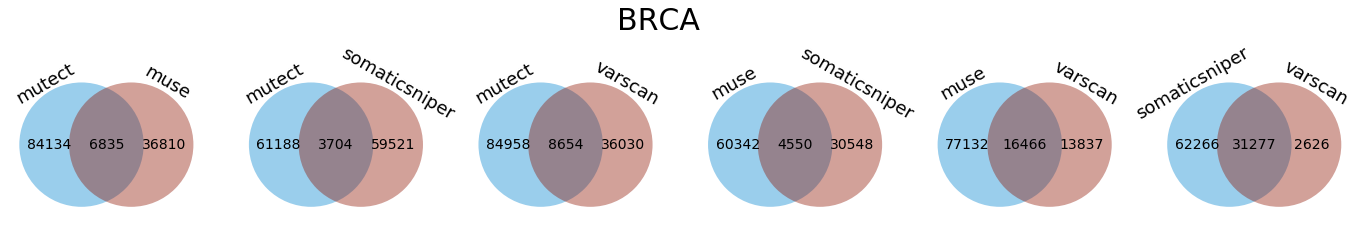

<Figure size 432x288 with 0 Axes>

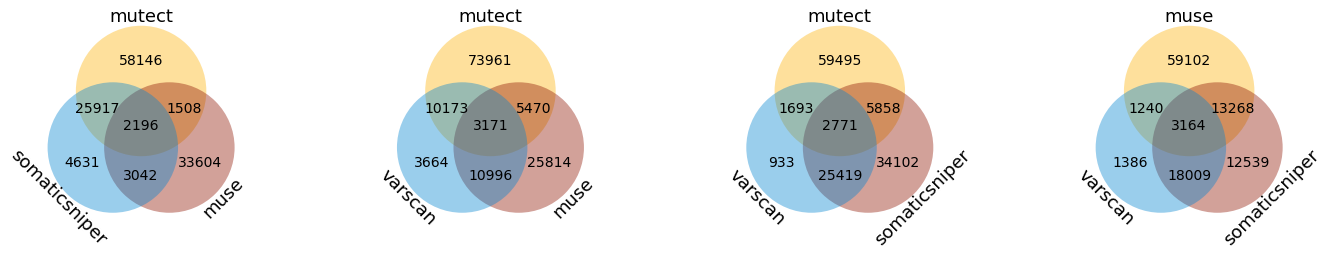

<Figure size 432x288 with 0 Axes>

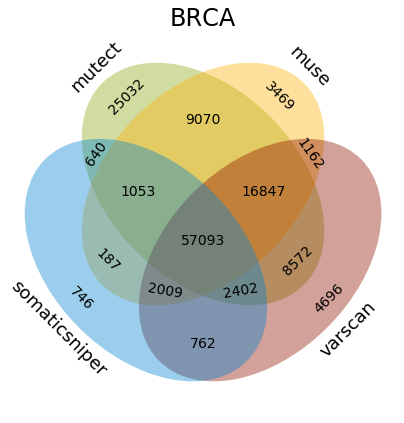

"\n# three-way venn\nsets = 'A B C'.split()\nsubsets = [1,2,3,4,5,6,7]\nax = axes[1]\nvenn3(subsets, ax=ax)\nax.set_title('venn3', fontsize=24)\n\n# four-way venn\nsets = 'A B C D'.split()\nsubsets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]\nax = axes[2]\nvenn4(subsets, ax=ax)\nax.set_title('venn4', fontsize=24)\n\nfig.suptitle('simple_venn Demo', fontsize=30)\nplt.savefig('demo.png', bbox_inches='tight')\n"

In [3]:
import matplotlib.pyplot as plt
from itertools import combinations
from simple_venn import venn2, venn3, venn4
def two_set_venn(dat_1, dat_2):
    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys()))
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        inter = len(set_1 & set_2)
        diff_1 = len(set_1 - set_2)
        diff_2 = len(set_2 - set_1)

        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
    
    dat.extend([diff_1_all, diff_2_all,inter_all])
    return dat


def three_set_venn(dat_1, dat_2, dat_3):

    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    inter_12_all = 0
    inter_13_all = 0
    inter_23_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys()))
    
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        inter = len(set_1 & set_2 & set_3)
        inter_12 = len(set_1 & set_2) - inter
        inter_13 = len(set_1 & set_3) - inter
        inter_23 = len(set_2 & set_3) - inter
        diff_1 = len(set_1) - inter - inter_13 - inter_12
        diff_2 = len(set_2) - inter - inter_12 - inter_23
        diff_3 = len(set_3) - inter - inter_13 - inter_23
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_23_all = inter_23_all + inter_23

    dat.extend([diff_1_all, diff_2_all, diff_3_all, inter_12_all, inter_13_all, inter_23_all,inter_all])
    return dat


def four_set_venn(dat_1, dat_2, dat_3, dat_4):
    dat = []
    inter_all = 0
    
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    diff_4_all = 0
    
    inter_12_all = 0
    inter_13_all = 0
    inter_14_all = 0
    inter_23_all = 0
    inter_24_all = 0
    inter_34_all = 0
    
    inter_123_all = 0
    inter_124_all = 0
    inter_134_all = 0
    inter_234_all = 0    
    
    set1_total = 0
    set2_total = 0
    set3_total = 0
    set4_total = 0
    
    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys())) & set(list(dat_4.keys()))
    total = 0
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        set_4 = dat_4[patient]
        
        set1_total = set1_total + len(set_1)
        set2_total = set2_total + len(set_2)
        set3_total = set3_total + len(set_3)
        set4_total = set4_total + len(set_4)
        
        
        inter = len(set_1 & set_2 & set_3 & set_4)
        inter_123 = len(set_1 & set_2 & set_3) - inter
        inter_124 = len(set_1 & set_2 & set_4) - inter
        inter_134 = len(set_1 & set_3 & set_4) - inter
        inter_234 = len(set_2 & set_3 & set_4) - inter
        
        
        inter_12 = len(set_1 & set_2) - inter - inter_123 - inter_124
        inter_13 = len(set_1 & set_3) - inter - inter_123 - inter_134
        inter_14 = len(set_1 & set_4) - inter - inter_124 - inter_134
        inter_23 = len(set_2 & set_3) - inter - inter_123 - inter_234
        inter_24 = len(set_2 & set_4) - inter - inter_124 - inter_234
        inter_34 = len(set_3 & set_4) - inter - inter_234 - inter_134
        
        diff_1 = len(set_1) - inter - inter_13 - inter_12 - inter_14 - inter_123 - inter_134 - inter_124
        diff_2 = len(set_2) - inter - inter_12 - inter_23 - inter_24 - inter_123 - inter_124 - inter_234
        diff_3 = len(set_3) - inter - inter_13 - inter_23 - inter_34 - inter_123 - inter_134 - inter_234
        diff_4 = len(set_4) - inter - inter_14 - inter_24 - inter_34 - inter_124 - inter_134 - inter_234
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        diff_4_all = diff_4_all + diff_4
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_14_all = inter_14_all + inter_14
        inter_23_all = inter_23_all + inter_23
        inter_24_all = inter_24_all + inter_24
        inter_34_all = inter_34_all + inter_34
        inter_123_all = inter_123_all + inter_123
        inter_124_all = inter_124_all + inter_124
        inter_134_all = inter_134_all + inter_134
        inter_234_all = inter_234_all + inter_234
        total = total + len(set_1 & set_2)
    
    #print(set1_total)
    #print(set2_total)
    #print(set3_total)
    #print(set4_total)
    
    dat.extend([diff_1_all, diff_2_all, diff_3_all, diff_4_all, inter_12_all, inter_13_all, inter_14_all,
                inter_23_all, inter_24_all, inter_34_all, inter_123_all, inter_124_all, inter_134_all, inter_234_all,inter_all]) 
    
    return dat


os.chdir(original)
os.chdir('BRCA')
mafs = os.listdir()

maf_fps = {}
for caller in possible_callers:
    for maf in mafs:
        if caller in maf: # str in the filepath
            maf_fps[caller] = maf

    #print(possible_callers)
    #print(maf_fps)

    # parse maf for each caller
all_variants = {}
for caller in maf_fps:
    all_variants[caller] = parse_maf(maf_fps[caller])
        
num_callers = len(possible_callers)
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
#two ways
sub = 0
for i in range(0, num_callers):
    if i == num_callers:
        break
    for j in range(i + 1, num_callers):
        dat = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
        sets = (possible_callers[i], possible_callers[j])
        subsets = dat
        ax = axes[sub]
        venn2(subsets, sets, ax=ax)
        ax.set_title('', fontsize=24)
        sub = sub+1

fig.suptitle('BRCA', fontsize=30)  
plt.show()
plt.clf()

fig, axes = plt.subplots(1, 4, figsize=(24, 4))
# three ways 
sub = 0
for i in range(0, num_callers):
    if i == num_callers:
        break
    for j in range(i + 1, num_callers):
        for k in range(j+1, num_callers):
            dat = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
            sets = (possible_callers[i], possible_callers[j],possible_callers[k])
            subsets = dat
            ax = axes[sub]
            venn3(subsets, sets, ax=ax)
            ax.set_title('', fontsize=24)
            sub = sub+1

plt.show()
plt.clf()
import numpy as np
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
#x = np.linspace(0,1,num=50)
#y = 8*np.power(x,2)

#plt.plot(x,y)
# four way intersection    
dat = four_set_venn(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]])
sets = (possible_callers[0], possible_callers[1],possible_callers[2], possible_callers[3])
subsets = dat
ax = axes
venn4(subsets, sets)
plt.title('BRCA', fontsize=24)
plt.show()


                    



# two-way venn

"""
# three-way venn
sets = 'A B C'.split()
subsets = [1,2,3,4,5,6,7]
ax = axes[1]
venn3(subsets, ax=ax)
ax.set_title('venn3', fontsize=24)

# four-way venn
sets = 'A B C D'.split()
subsets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ax = axes[2]
venn4(subsets, ax=ax)
ax.set_title('venn4', fontsize=24)

fig.suptitle('simple_venn Demo', fontsize=30)
plt.savefig('demo.png', bbox_inches='tight')
"""